# Education

In this assessment, you'll apply `pandas` and `seaborn` to process and visualize education statistics.

The [National Center for Education Statistics](https://nces.ed.gov/) is a U.S. federal government agency for collecting and analyzing data related to education. We have downloaded and cleaned one of their datasets: *[Percentage of persons 25 to 29 years old with selected levels of educational attainment, by race/ethnicity and sex: Selected years, 1920 through 2018](https://nces.ed.gov/programs/digest/d18/tables/dt18_104.20.asp)*.

In [1]:
# For testing purposes
from matplotlib.patches import Rectangle
from pandas.testing import assert_series_equal

import pandas as pd
import seaborn as sns

sns.set_theme()

The `nces-ed-attainment.csv` file has the columns `Year`, `Sex`, `Min degree`, and percentages for each subdivision of 25 to 29 year-olds in the specified year, sex, and min degree. The data is represented as a `pandas` `DataFrame` with the following `MultiIndex` and columns.

- `Year` is the first level of the `MultiIndex` with values ranging from 1920 to 2018.
- `Sex` is the second level of the `MultiIndex` with values `F` for female, `M` for male, or `A` for all students.
- `Min degree` is the third level of the `MultiIndex` with values referring to the minimum degree of educational attainment: `high school`, `associate's`, `bachelor's`, or `master's`.
- `Total` is the overall percentage of the given `Sex` population in the `Year` with at least the `Min degree` of educational attainment.
- `White`, `Black`, `Hispanic`, `Asian`, `Pacific Islander`, `American Indian/Alaska Native`, and `Two or more races` is the percentage of students of the specified racial category (and of the `Sex` in the `Year`) with at least the `Min degree` of educational attainment.

Missing data is denoted `NaN` (not a number).

In [3]:
data = pd.read_csv(
    "nces-ed-attainment.csv",
    na_values=["---"],
    index_col=["Year", "Sex", "Min degree"]
).sort_index(level="Year", sort_remaining=False)
data

Total  White  Black  Hispanic  Asian  Pacific Islander  \
Year Sex Min degree                                                            
1920 A   high school    NaN   22.0    6.3       NaN    NaN               NaN   
         bachelor's     NaN    4.5    1.2       NaN    NaN               NaN   
1940 A   high school   38.1   41.2   12.3       NaN    NaN               NaN   
         bachelor's     5.9    6.4    1.6       NaN    NaN               NaN   
1950 A   high school   52.8   56.3   23.6       NaN    NaN               NaN   
...                     ...    ...    ...       ...    ...               ...   
2018 M   master's       7.3    7.7    2.8       3.1   28.6               NaN   
     F   high school   94.0   96.3   93.2      87.2   97.4              91.8   
         associate's   51.5   59.6   35.8      34.2   76.9              23.6   
         bachelor's    40.8   48.4   26.2      23.2   71.5              13.5   
         master's      10.7   12.6    6.2       3.8   29.9               NaN   

                      American Indian/Alaska Native  Two or more races  
Year Sex Min degree                                                     
1920 A   high school                            NaN                NaN  
         bachelor's                             NaN                NaN  
1940 A   high school                            NaN                NaN  
         bachelor's                             NaN                NaN  
1950 A   high school                            NaN                NaN  
...                                             ...                ...  
2018 M   master's                               NaN                NaN  
     F   high school                           95.1               93.8  
         associate's                           32.8               48.2  
         bachelor's                            22.5               28.7  
         master's                               NaN                NaN  

[214 rows x 8 columns]

The cell above reads `nces-ed-attainment.csv` and replaces all occurrences of the `str` `---` with `pandas` `NaN` to help with later data processing steps. By defining a `MultiIndex` on the columns `Year`, `Sex`, and `Min degree`, we can answer questions like "What is the overall percentage of all 25 to 29 year-olds in the year 2018 who have at least a high school degree?" with the following `df.loc[index, columns]` expression.

In [14]:
data.loc[(2018, "A", "high school"), "Total"]

92.9

For this assessment, instead of writing test cases, we'll only be working with the educational attainment dataset described above. We've provided one test case for each function that includes the exact expected values for each function. Instead of extending the test cases, you'll be asked to write-up and reason about the quality of work demonstrated in each task.

## Task: Compare bachelor's in a given year

Write a function `compare_bachelors_year` that takes the educational attainment `data` and a year and returns a two-row `Series` that indicates the percentages of M/F 25 to 29 year-olds who achieved at least a bachelor's degree in the given year.

In [43]:
def compare_bachelors_year(data, year):
    # Initialize an empty Series to hold the result with the correct MultiIndex
    output_index = pd.MultiIndex.from_product([[year], ['M', 'F'], ["bachelor's"]], names=['Year', 'Sex', 'Min degree'])
    output = pd.Series(index=output_index)
    output.name = "Total"

    # Attempt to fetch the bachelor's degree statistics for males and females
    for sex in ['M', 'F']:
        try:
            output[(year, sex, "bachelor's")] = data.loc[(year, sex, "bachelor's"), 'Total']
        except:
            output[(year, sex, "bachelor's")] = pd.NA  # handles edge case where the result is NaN

    return output

output = compare_bachelors_year(data, 1980)
assert_series_equal(output, pd.Series([24., 21.], name="Total",
    index=pd.MultiIndex.from_product([[1980], ["M", "F"], ["bachelor's"]], names=data.index.names)
))
output

Year  Sex  Min degree
1980  M    bachelor's    24.0
      F    bachelor's    21.0
Name: Total, dtype: float64

## Task: Mean min degree between given years for a given category

Write a function `mean_min_degrees` that takes the educational attainment `data`, a `start_year` (default `None`), an `end_year` (default `None`), a string `category` (default `"Total"`) and returns a `Series` indicating, for each `Min degree` within the given years, the average percentage of educational attainment for people of the given `category` between the `start_year` and the `end_year` for the sex `A`. When `start_year` or `end_year` is `None`, consider all rows from either the beginning or end of the dataset (respectively).

In [87]:
def mean_min_degrees(data, start_year=None, end_year=None, category="Total"):
    if start_year is None:
        start_year = data.index.get_level_values('Year').min()
    if end_year is None:
        end_year = data.index.get_level_values('Year').max()

    filtered_data = data.loc[(slice(start_year, end_year), 'A', slice(None)), :]
    means = filtered_data.groupby('Min degree')[category].mean()

    return means


output = mean_min_degrees(data, start_year=2000, end_year=2009)
assert_series_equal(output, pd.Series([38.366667, 29.55, 87.35, 6.466667], name="Total",
    index=pd.Index(["associate's", "bachelor's", "high school", "master's"], name="Min degree")
))
output

Min degree
associate's    38.366667
bachelor's     29.550000
high school    87.350000
master's        6.466667
Name: Total, dtype: float64

## Writeup: Debugging `NaN` values

While writing test cases, one of your coworkers noticed that some calls to `mean_min_degrees` produce `NaN` values and wanted your opinion on whether or not this is a bug with the function. **[Using the data source](https://nces.ed.gov/programs/digest/d18/tables/dt18_104.20.asp), explain why a `NaN` value appears in the result of the following code cell.**

The NaN value appearing in the output for the master's degree row, when querying the educational attainment for Pacific Islanders, can be attributed directly to the dataset's representation of missing data with '---'. During the preprocessing phase of this data analysis, all occurrences of '---' were converted to pd.NA (pandas' representation for missing values or NaN). This conversion is crucial for handling missing data within pandas effectively.

Since the dataset contains '---' for every entry related to Pacific Islanders across all years, no data points are available to calculate an average or mean for the master's degree category for this group. Consequently, when the mean_min_degrees function attempts to compute the average educational attainment for Pacific Islanders, it results in a NaN value for the master's degree row. This outcome is due to the complete absence of data for Pacific Islanders in the source regarding master's degrees, thereby preventing the calculation of a meaningful average.

In [78]:
mean_min_degrees(data, category="Pacific Islander")

Min degree
associate's    29.838462
bachelor's     19.853846
high school    93.450000
master's             NaN
Name: Pacific Islander, dtype: float64

## Task: Line plot for total percentage for the given min degree

Write a function `line_plot_min_degree` that takes the educational attainment `data` and a min degree and returns the result of calling `sns.relplot` to produce a line plot. The resulting line plot should show only the `Total` percentage for sex `A` with the specified min degree over each year in the dataset. Label the x-axis "Year", the y-axis "Percentage", and title the plot "Min degree for all bachelor's" (if using bachelor's as the min degree).

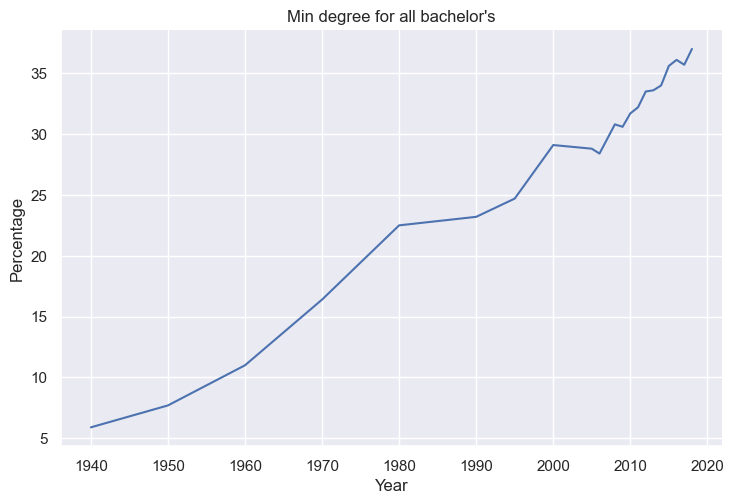

In [132]:
def line_plot_min_degree(data, min_degree):
    filtered_data = data.loc[(slice(None), "A", min_degree), "Total"].reset_index()
    plot = sns.relplot(data=filtered_data, x="Year", y="Total", kind="line", height=5, aspect=1.5)
    plot.set_xlabels("Year")
    plot.set_ylabels("Percentage")
    title = "Min degree for all " + min_degree
    plot.fig.axes[0].set_title(title)
    return plot


ax = line_plot_min_degree(data, "bachelor's").facet_axis(0, 0)
assert [tuple(xy) for xy in ax.get_lines()[0].get_xydata()] == [
    (1940,  5.9), (1950,  7.7), (1960, 11.0), (1970, 16.4), (1980, 22.5), (1990, 23.2),
    (1995, 24.7), (2000, 29.1), (2005, 28.8), (2006, 28.4), (2007, 29.6), (2008, 30.8),
    (2009, 30.6), (2010, 31.7), (2011, 32.2), (2012, 33.5), (2013, 33.6), (2014, 34.0),
    (2015, 35.6), (2016, 36.1), (2017, 35.7), (2018, 37.0),
], "data does not match expected"
assert all(line.get_xydata().size == 0 for line in ax.get_lines()[1:]), "unexpected extra data"
assert ax.get_title() == "Min degree for all bachelor's", "title does not match expected"
assert ax.get_xlabel() == "Year", "x-label does not match expected"
assert ax.get_ylabel() == "Percentage", "y-label does not match expected"

## Task: Bar plot for high school min degree percentage by sex in a given year

Write a function `bar_plot_high_school_compare_sex` that takes the educational attainment `data` and a year and returns the result of calling `sns.catplot` to produce a bar plot. The resulting bar plot should compare the total percentages of `Sex` `A`, `M`, and `F` with `high school` `Min degree` in the given year. Label the x-axis "Sex", the y-axis "Percentage", and title the plot "High school completion in 2009" (if using 2009 as the year).

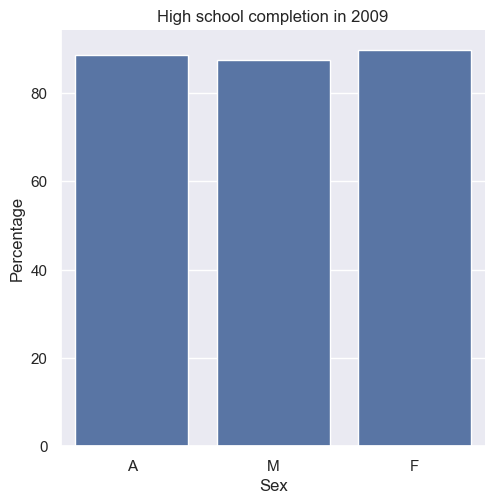

In [138]:
def bar_plot_high_school_compare_sex(data, year):
    # filtered_data = data.loc[(slice(None), "A", min_degree), "Total"].reset_index()
    filtered_data = data.loc[(year, slice(None), 'high school'), 'Total'].reset_index()
    filtered_data.columns = ['Year', 'Sex', 'Min degree', 'Total']

    filtered_data['Total'] = pd.to_numeric(filtered_data['Total'], errors='coerce')

    filtered_data = filtered_data[filtered_data['Sex'].isin(['A', 'M', 'F'])]

    plot = sns.catplot(
        data = filtered_data,
        x = 'Sex', y='Total', kind='bar',
        height=5, aspect=1
    )

    plot.set_axis_labels("Sex", "Percentage")
    title = "High school completion in " + str(year)
    plot.fig.axes[0].set_title(title)

    return plot

ax = bar_plot_high_school_compare_sex(data, 2009).facet_axis(0, 0)
assert sorted(rectangle.get_height() for rectangle in ax.findobj(Rectangle)[:3]) == [
    87.5, 88.6, 89.8,
], "data does not match expected"
assert len(ax.findobj(Rectangle)) == 4, "too many rectangles drawn" # ignore background Rectangle
assert ax.get_title() == "High school completion in 2009", "title does not match expected"
assert ax.get_xlabel() == "Sex", "x-label does not match expected"
assert ax.get_ylabel() == "Percentage", "y-label does not match expected"

## Writeup: Bar plot versus scatter plot

1. Read Kieran Hiely's comparison of bar plot versus scatter plot from *Data Visualization* section 1.6: [Problems of honesty and good judgment](https://socviz.co/lookatdata.html#problems-of-honesty-and-good-judgment).
1. Compare your bar plot for high school completion in 2009 to the scatter plot below.
1. **Which plot do you prefer and why?**

I prefer the bar plot much more over the scatter plot. One obvious reason is that it is just easier to interpret since the data points aren't so small. When we are dealing with percentages as well, it is more intuitive and easier for the interpreter/reader to see things on a scale of 0-100 since these are the only values a percentage can take on. Since the scatter plot is a more zoomed in look at the data, it makes it seem as if the difference between A M and F is huge. However, if you look at the values on the left and the bar chart, you notice that these differences, although existent, are quite small. The article argued that bar charts conventionally start at 0 which is accurate in this case. This makes me more inclined to choose the bar chart since we can see the full range of a percentage and also deduce that these 3 sex's are all actually very close together in completion which would require slightly more (although very slight) looking into to come to the same conclusion.

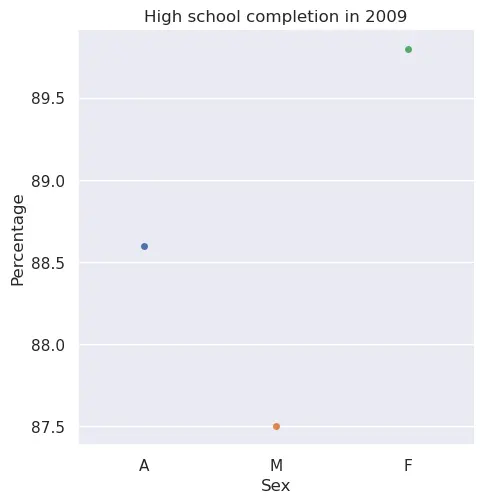

## Task: Plot for min degree percentage over time for a given racial category

Write a function `plot_race_compare_min_degree` that takes the educational attainment `data` and a string category and returns the result of calling the `sns` plotting function that best visualizes this data. The resulting plot should compare each of the 4 `Min degree` options, indicating the percentage of educational attainment for the given racial category and `Min degree` over the entire time range of available data. Due to missing data, not all min degree options will stretch the entire width of the plot. Label the x-axis "Year", the y-axis "Percentage", and title the plot "Min degree for Hispanic" (if using Hispanic as the racial category).

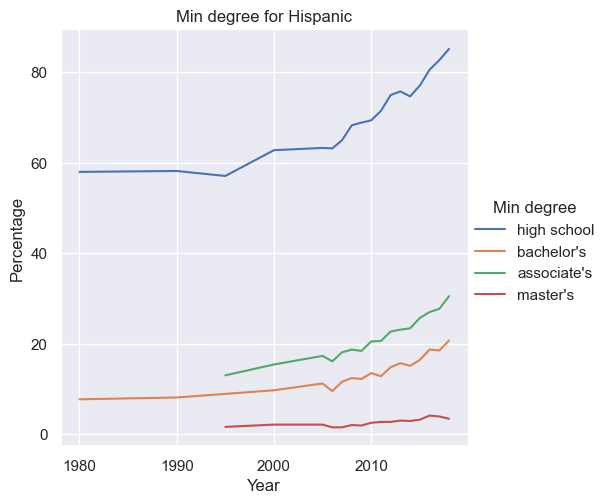

In [173]:
def plot_race_compare_min_degree(data, category):
  # data.loc[(2018, "A", "high school"), "Total"]
  filtered_data = data.loc[(slice(None), "A", slice(None)), category].reset_index()

  plot = sns.relplot(data=filtered_data, x="Year", y=filtered_data[category], hue="Min degree", kind='line')
  plot.set_axis_labels("Year", "Percentage")
  title = "Min degree for " + category
  plot.fig.axes[0].set_title(title)

  return plot


ax = plot_race_compare_min_degree(data, "Hispanic").facet_axis(0, 0)
assert sorted([tuple(xy) for xy in line.get_xydata()] for line in ax.get_lines()[:4]) == [
    [(1980,  7.7), (1990,  8.1), (1995,  8.9), (2000,  9.7), (2005, 11.2), (2006,  9.5),
     (2007, 11.6), (2008, 12.4), (2009, 12.2), (2010, 13.5), (2011, 12.8), (2012, 14.8),
     (2013, 15.7), (2014, 15.1), (2015, 16.4), (2016, 18.7), (2017, 18.5), (2018, 20.7)],
    [(1980, 58.0), (1990, 58.2), (1995, 57.1), (2000, 62.8), (2005, 63.3), (2006, 63.2),
     (2007, 65.0), (2008, 68.3), (2009, 68.9), (2010, 69.4), (2011, 71.5), (2012, 75.0),
     (2013, 75.8), (2014, 74.7), (2015, 77.1), (2016, 80.6), (2017, 82.7), (2018, 85.2)],
    [                            (1995,  1.6), (2000,  2.1), (2005,  2.1), (2006,  1.5),
     (2007,  1.5), (2008,  2.0), (2009,  1.9), (2010,  2.5), (2011,  2.7), (2012,  2.7),
     (2013,  3.0), (2014,  2.9), (2015,  3.2), (2016,  4.1), (2017,  3.9), (2018,  3.4)],
    [                            (1995, 13.0), (2000, 15.4), (2005, 17.3), (2006, 16.1),
     (2007, 18.1), (2008, 18.7), (2009, 18.4), (2010, 20.5), (2011, 20.6), (2012, 22.7),
     (2013, 23.1), (2014, 23.4), (2015, 25.7), (2016, 27.0), (2017, 27.7), (2018, 30.5)],
], "data does not match expected"
assert all(line.get_xydata().size == 0 for line in ax.get_lines()[4:]), "unexpected extra data"
assert ax.get_title() == "Min degree for Hispanic", "title does not match expected"
assert ax.get_xlabel() == "Year", "x-label does not match expected"
assert ax.get_ylabel() == "Percentage", "y-label does not match expected"

## Task: Line plot comparing educational attainment by race over time

Write a function `line_plot_compare_race` that reproduces [the following line plot](https://periscopic.com/#!/impacts/americas-educational-attainment) using `seaborn` to compare the given `Min degree` attainment across all columns except for `Total` and `Two or more races` for sex `A` and years 2009 onward. Our dataset separates "Asian" and "Pacific Islander", which you can keep separate in your plot for simplicity even though they are combined in the interactive report. Label the x-axis "Year", the y-axis "Percentage", and title the plot "Attainment by race for all associate's" (if using associate's as the min degree).

<video style="max-width: 100%; max-height: 480px" loop="true" autoplay="true" muted="true" src="https://content.periscopic.com/uploads/46c2238b38244e86be008eb9898533bf.mp4"></video>

This task involves reading documentation and learning additional methods to solve the problem because `seaborn` plotting functions typically only accept data in a single column, whereas our dataset spreads educational attainment per race across several columns. For an additional challenge, don't read the recommended approach below.

<details>
<summary>Recommended approach</summary>

<ol>
<li>Select all rows where <code>Year</code> is 2009 and onwards and <code>Min degree</code> matches the given string.</li>
<li>Read the documentation for <code><a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.melt.html">DataFrame.melt</a></code> to learn how to combine all the racial categories into a single column. Be sure to include the keyword argument <code>ignore_index=False</code> to keep the current <code>MultiIndex</code>. The <a href="https://pandas.pydata.org/docs/user_guide/reshaping.html#melt-and-wide-to-long">corresponding section in the user guide</a> may also be helpful.</li>
<li>Read the documentation for <code><a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html">DataFrame.set_index</a></code> to learn how to append the combined race categories column as another level of the <code>MultiIndex</code>. Be sure to include the keyword argument <code>append=True</code>.</li>
<li>Pass the melted, 4-level-indexed dataframe to the appropriate figure-level plotting function to produce your plot.</li>
</ol>
</details>

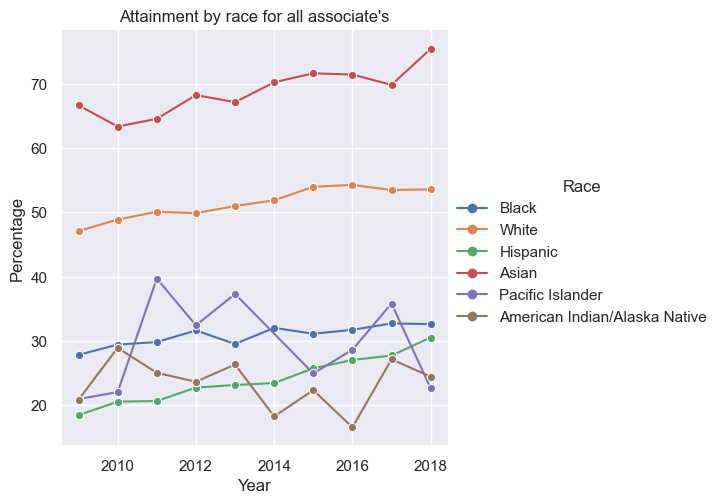

In [254]:
def line_plot_compare_race(data, min_degree):
    filtered_data = data.loc[(slice(2009, None), "A", min_degree), :].reset_index()
    melt = pd.melt(filtered_data, id_vars=["Year", "Sex", "Min degree"],
                          value_vars=['Black', "White", "Hispanic", "Asian", "Pacific Islander", "American Indian/Alaska Native"],
                          var_name='Race', value_name='Percentage', ignore_index=False)
    melt = melt.set_index('Race', append=True)

    plot = sns.relplot(data=melt, x='Year', y='Percentage', hue='Race', marker='o', kind='line')
    plot.set_axis_labels("Year", "Percentage")
    title = "Attainment by race for all " + min_degree
    plot.fig.axes[0].set_title(title)

    return plot

ax = line_plot_compare_race(data, "associate's").facet_axis(0, 0)
assert sorted([tuple(xy) for xy in line.get_xydata()] for line in ax.get_lines()[:6]) == [
    [(2009.0, 18.4), (2010.0, 20.5), (2011.0, 20.6), (2012.0, 22.7), (2013.0, 23.1),
     (2014.0, 23.4), (2015.0, 25.7), (2016.0, 27.0), (2017.0, 27.7), (2018.0, 30.5)],
    [(2009.0, 20.8), (2010.0, 28.9), (2011.0, 25.0), (2012.0, 23.6), (2013.0, 26.3),
     (2014.0, 18.2), (2015.0, 22.3), (2016.0, 16.5), (2017.0, 27.1), (2018.0, 24.4)],
    [(2009.0, 20.9), (2010.0, 22.0), (2011.0, 39.7), (2012.0, 32.4), (2013.0, 37.3),
                     (2015.0, 24.9), (2016.0, 28.6), (2017.0, 35.8), (2018.0, 22.6)],
    [(2009.0, 27.8), (2010.0, 29.4), (2011.0, 29.8), (2012.0, 31.6), (2013.0, 29.5),
     (2014.0, 32.0), (2015.0, 31.1), (2016.0, 31.7), (2017.0, 32.7), (2018.0, 32.6)],
    [(2009.0, 47.1), (2010.0, 48.9), (2011.0, 50.1), (2012.0, 49.9), (2013.0, 51.0),
     (2014.0, 51.9), (2015.0, 54.0), (2016.0, 54.3), (2017.0, 53.5), (2018.0, 53.6)],
    [(2009.0, 66.7), (2010.0, 63.4), (2011.0, 64.6), (2012.0, 68.3), (2013.0, 67.2),
     (2014.0, 70.3), (2015.0, 71.7), (2016.0, 71.5), (2017.0, 69.9), (2018.0, 75.5)],
], "data does not match expected"
assert all(line.get_xydata().size == 0 for line in ax.get_lines()[6:]), "unexpected extra data"
assert ax.get_title() == "Attainment by race for all associate's", "title does not match expected"
assert ax.get_xlabel() == "Year", "x-label does not match expected"
assert ax.get_ylabel() == "Percentage", "y-label does not match expected"

## Writeup: Visualizations and persuasive rhetoric

Visualizations are persuasive even when we design them using communication practices that aim to create an "unemotional", "distanced", or "neutral" analysis. For instance, the choice of bar plot versus scatter plot brings with it different baggage: readers make different assumptions about the data based on the type of plot and its visual presentation. And, as we experienced in the final programming task, the data itself can be structured in such a way as to make some data visualizations easier to produce than others, affording (making more likely) certain data analyses over other data analyses.

Consider this alternative title for your final programming task. **[Using the Progress toward Racial Equity interactive report](https://www.luminafoundation.org/stronger-nation/report/#/progress/racial_equity&equity-time-age=25_34&equity-geo-age=25_34), explain how this alternative title might suggest a misleading, incomplete, or otherwise harmful conclusion about racial equity in educational attainment.**

*Replace this text with your answer.*

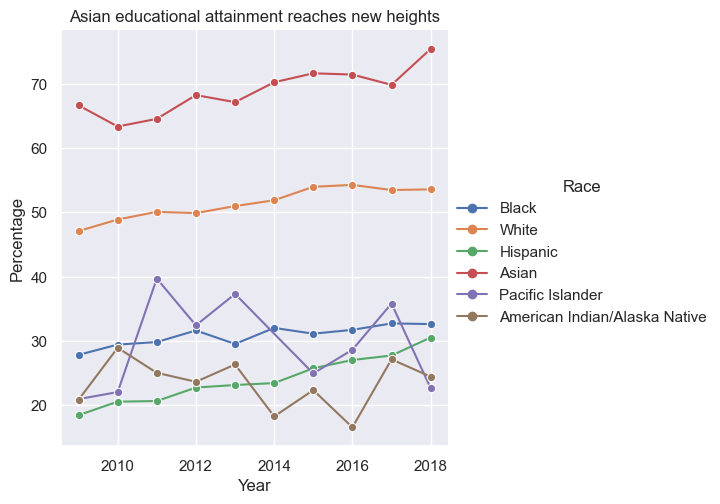

In [255]:
line_plot_compare_race(data, "associate's").set(title="Asian educational attainment reaches new heights")